In [1]:
import sys
sys.path.append('../')
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Imputer
from util import *
from onehot import LabelBinarizerEx
from pipeline import FeaturePipeline, DataFramePipeline
from binning import Binner
from ensemble import EnsembleStackClassifierEx
from addcols import AddColumns
from impute import GroupImputer
from ordinal import Ordinar

%matplotlib inline
from matplotlib import pyplot

C:\apps\Anaconda2\envs\handson\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## explore data

In [2]:
import pandas as pd
house_train=pd.read_csv('train.csv')
target_col='SalePrice'
id_col='Id'
target=house_train[target_col]/house_train['LotArea']

In [3]:
num_summary=house_train.describe()
# num_summary

In [4]:
cat_summary=house_train.describe(include=['O'])
# cat_summary

add unit price

In [5]:
# house_train['UnitPrice']=house_train[target_col]/house_train['LotArea']

explore features

In [6]:
# corrs=house_train.corr()[['UnitPrice']]
# corrs.sort_values('UnitPrice',ascending=False)

In [7]:
# df=house_train.groupby('LotShape').mean()[['UnitPrice']]
# df.plot(kind='bar')

LotShape is ordinal

'Reg' is max

In [8]:
# corrs['UnitPrice']['LotFrontage']

LotFrontage is slight neg corr with up

it should be discretized

In [9]:
# corrs['UnitPrice']['LotArea']

same with LotFrontage

In [10]:
# df=house_train.groupby('Utilities').mean()[['UnitPrice']]
# df.sort_values('UnitPrice').plot(kind='bar')

make Utilities ordinal

In [11]:
# df=house_train.groupby('LandSlope').mean()[['UnitPrice']]
# df.sort_values('UnitPrice').plot(kind='bar')

make LandSlope ordinal

merge condition1&2 into 1 col

In [12]:
# df=house_train.groupby('HouseStyle').mean()[['UnitPrice']].sort_values('UnitPrice')
# df.plot(kind='bar')

make HouseStyle ordinal , SLvl is max

In [13]:
# corrs['UnitPrice']['YearRemodAdd']

discretize YearBuilt, band is 9

In [14]:
# house_train['YearTotal']=house_train['YearRemodAdd']+house_train['YearBuilt']
# house_train['YearTotalBand']=pd.qcut(house_train['YearTotal'],6,labels=False,duplicates='drop')
# corrs=house_train.corr()
# corrs['UnitPrice'][['YearBuilt','YearBand','YearTotal','YearRemodAdd','YearTotalBand']]

add YearBuilt & YearRemodAdd to make YearTotal, discretize it

make ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,FireplaceQu,GarageFinish, GarageQual, GarageCond, PoolQC, Fence, ordinal

In [15]:
# df=house_train.groupby('RoofStyle').mean()[['UnitPrice']].sort_values('UnitPrice')
# df.plot(kind='bar')

## feature enginering

In [16]:
drop_cols=[id_col,target_col]

In [17]:
num_cols=list(num_summary.columns)
num_cols=list(filter(lambda c: c not in drop_cols, num_cols))

In [18]:
num_band_cols=list(filter(lambda c: len(house_train[c].unique())>20 , num_cols))
num_normal_cols=set(num_cols)-set(num_band_cols)

In [19]:
cat_cols=cat_summary.columns

In [20]:
cat_ordinals={
    'LotShape':['IR3','IR2','IR1','Reg'],
    'Utilities':['ELO','NoSeWa','NoSewr','AllPub'],
    'LandSlope':['Sev','Mod','Gtl',],
    'HouseStyle':['1Story','1.5Fin','1.5Unf','2Story','2.5Fin','2.5Unf','SFoyer','SLvl'],
    'ExterQual':['po','fa','ta','gd','ex'],
    'BsmtQual':['po','fa','ta','gd','ex'],
    'BsmtCond':['po','fa','ta','gd','ex'],
    'BsmtExposure':['no','mn','av','gd'],
    'BsmtFinType1':['unf','lwq','rec','blq','alq','glq'],
    'BsmtFinType2':['unf','lwq','rec','blq','alq','glq'],
    'HeatingQC':['po','fa','ta','gd','ex'],
    'KitchenQual':['po','fa','ta','gd','ex'],
    'Functional':['sal','sev','maj2','maj1','mod','min2','min1','typ'],
    'FireplaceQu':['po','fa','ta','gd','ex'],
    'GarageFinish':['unf','rfn','fin'], 
    'GarageQual':['po','fa','ta','gd','ex'],
    'GarageCond':['po','fa','ta','gd','ex'], 
    'PoolQC':['fa','ta','gd','ex'], 
    'Fence':['mnww','gdwo','mnprv','gdprv']
}
cat_ordinal_cols=cat_ordinals.keys()

In [21]:
cat_type_cols=set(cat_cols)-cat_ordinal_cols

In [22]:
num_pipelines=[FeaturePipeline(c,c,Pipeline([('impute',Imputer(strategy='median')),('scale',StandardScaler())])) 
               for c in num_cols]
cat_type_pipelines=[FeaturePipeline(c,'',Pipeline([('onehot',LabelBinarizerEx([c]))])) for c in cat_type_cols]
cat_ordinal_pipelines=[FeaturePipeline(c,c,Pipeline([('ordinal',Ordinar(cat_ordinals[c])),('scale',StandardScaler())])) 
                       for c in cat_ordinal_cols]
full_pipeline=DataFramePipeline(num_pipelines+cat_type_pipelines+cat_ordinal_pipelines)
prepared_house_train=full_pipeline.fit_transform(house_train)
prepared_house_train.drop(drop_cols+list(cat_type_cols),axis=1,inplace=True)
prepared_house_train.head()

,MSSubClass,LotFrontage,LotArea,LotShape,Utilities,LandSlope,HouseStyle,OverallQual,OverallCond,YearBuilt,...,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,PavedDrive_N,PavedDrive_P,PavedDrive_Y
0,0.073375,-0.220875,-0.207142,0.701291,0.02618,0.225716,0.735964,0.651479,-0.517200,1.050994,...,0,0,0,0,0,0,0,0,0,1
1,-0.872563,0.460320,-0.091886,0.701291,0.02618,0.225716,-0.799778,-0.071836,2.179628,0.156734,...,0,0,0,0,0,0,1,0,0,1
2,0.073375,-0.084636,0.073480,-1.016637,0.02618,0.225716,0.735964,0.651479,-0.517200,0.984752,...,0,0,0,0,0,0,0,0,0,1
3,0.309859,-0.447940,-0.096897,-1.016637,0.02618,0.225716,0.735964,0.651479,-0.517200,-1.863632,...,0,0,0,0,0,0,0,0,0,1
4,0.073375,0.641972,0.375148,-1.016637,0.02618,0.225716,0.735964,1.374795,-0.517200,0.951632,...,0,0,0,0,0,0,0,0,0,1


## train

In [23]:
from sklearn.linear_model import SGDClassifier,LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,AdaBoostRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor

base_regs=[
#     LinearRegression(n_jobs=-1),
#     SVC(probability=True),
    RandomForestRegressor(n_jobs=-1),
#     ExtraTreesRegressor(n_jobs=-1),
    GradientBoostingRegressor(),
    XGBRegressor(),
]

In [24]:
from sklearn.model_selection import cross_val_score
from math import sqrt,log10

%matplotlib inline
import matplotlib.pyplot as plt
from pylab import *

def trainModels(train_data, target):
    scores=[log10(sqrt(-cross_val_score(reg,train_data,target,scoring='neg_mean_squared_error',cv=5,n_jobs=-1,verbose=1).mean())) 
            for reg in base_regs]

    labels=[c.__class__.__name__[:3] for c in base_regs]
    X=np.arange(len(base_regs))
    bar(X,scores,tick_label=labels,color='rgb')
#     ylim(0.5,1.0)
    show()
    print(sorted(zip(labels,scores),key=lambda x:x[1],reverse=True))

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished


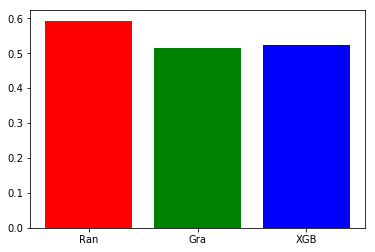

[('Ran', 0.59310743310211211), ('XGB', 0.52340257466181073), ('Gra', 0.51502431696780493)]


In [25]:
trainModels(prepared_house_train,target)

In [26]:
best_reg=GradientBoostingRegressor()
best_reg.fit(prepared_house_train,target)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

## tuning

In [27]:
from sklearn.model_selection import GridSearchCV

param_grid_set=[
#                 {'C':[0.01,0.1,0.5,1.]},
#                 {'C':[1.,10.,],'kernel':['rbf','poly'],'gamma':[0.01,0.1,1.],'coef0':[1.,10.,]},
                {'n_estimators':[50,100,200,300],'max_depth':[5,10,15]},
                {'learning_rate':[0.01,0.1,1.0],'n_estimators':[100,200,300],'max_depth':[3,5,8]},
#                 {'learning_rate':[0.01,0.1,1.0],'n_estimators':[100,200,300]},
#                 {'n_estimators':[50,100,200,300],'max_depth':[5,10,15]},
                {'learning_rate':[0.01,0.1,1.0],'n_estimators':[100,200,300],'max_depth':[5,10,15],'gamma':[0.01,0.1,0.5]},
               ]

def tuneModels(train_data,target):
    results=[]
    for i in range(len(base_regs)):
        gs=GridSearchCV(estimator=base_regs[i],param_grid=param_grid_set[i],scoring='neg_mean_squared_error',n_jobs=-1,verbose=1,cv=5)
        gs.fit(train_data,target)
        results.append((gs.best_estimator_,gs.best_score_))
    print(sorted(results,key=lambda x:x[1],reverse=True))
    return results

In [28]:
# results=tuneModels(prepared_house_train,target)

## test

In [29]:
house_test=pd.read_csv('test.csv')
test_drop_cols=list(filter(lambda c: c != target_col, drop_cols))

In [30]:
test_id=house_test[id_col]
prepared_house_test=full_pipeline.transform(house_test)
prepared_house_test.drop(test_drop_cols+list(cat_type_cols),axis=1,inplace=True)


In [31]:
prices=best_reg.predict(prepared_house_test)*house_test['LotArea']
df=pd.DataFrame({id_col:test_id,target_col:prices.astype(int)})
df.to_csv('result.csv',index=False)